In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [40]:
data = pd.read_csv('Life_Expectancy_Data.csv') #Cargar base de datos.
data.columns = data.columns.str.strip() #Quitar Espacios en los nombre de columnas en caso que existan.
data_before_imputation = data.copy()

#Estas variables están elegidas dado que abordan distintos factores que influyen en la salud: educación, ingresos, 
#Condiciones económicas y hábitos de consumo que pueden afectar la esperanza de vida.

#Es necesario aplicar Lasso u otra tecnica para verificar los mejores predictores del data-set.

predictors = ['Schooling', 'Income composition of resources', 'GDP', 'Alcohol']
target = ['Life expectancy']

print('-------------------Verificación de filas duplicadas---------------------------------------')

# Verificar si hay filas duplicadas
duplicados = data.duplicated().sum()
print(f"Número de filas duplicadas: {duplicados}")

print('------------------------------------------------------------------------------------------')

# Eliminar duplicados si los hay
if duplicados > 0:
    data = data.drop_duplicates()
    print("Duplicados eliminados")
print('------------------------------------------------------------------------------------------')

print('--------------------- Análisis de Datos NaN/Null ---------------------------------')

# Verificar si hay valores faltantes Variables Predictoras
columns_to_check = ['Schooling', 'Income composition of resources', 'GDP', 'Alcohol']
print(data[columns_to_check].isnull().sum())



#Verificar si hay valores Faltantes o NaN en Espectativa de vida.

nulos_life_expectancy = data['Life expectancy'].isnull().sum()
print(f"Número de valores NaN/Null en 'Life expectancy': {nulos_life_expectancy}")



-------------------Verificación de filas duplicadas---------------------------------------
Número de filas duplicadas: 0
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
--------------------- Análisis de Datos NaN/Null ---------------------------------
Schooling                          163
Income composition of resources    167
GDP                                448
Alcohol                            194
dtype: int64
Número de valores NaN/Null en 'Life expectancy': 10


In [41]:
#Aplicamos Imputación por Mediana a Life Expectancy, debido a que evita distorciones significativas.
data['Life expectancy'].fillna(data['Life expectancy'].median(), inplace=True)

# Aplicar interpolación lineal a Schooling y Income.
data['Schooling'] = data['Schooling'].interpolate(method='linear')
data['Income composition of resources'] = data['Income composition of resources'].interpolate(method='linear')


#Imputar GDP y Alcohol con la media del grupo por país para evitar distorsiones, dado que la variabilidad de los datos en estas columnas puede ser grande.
data['GDP'] = data.groupby('Country')['GDP'].transform(lambda x: x.fillna(x.mean()))
data['Alcohol'] = data.groupby('Country')['Alcohol'].transform(lambda x: x.fillna(x.mean()))

# Imputar los valores restantes con la media global
data['GDP'] = data['GDP'].fillna(data['GDP'].mean())
data['Alcohol'] = data['Alcohol'].fillna(data['Alcohol'].mean())

print(f"El número de valores NaN restantes en la columna 'Life expectancy' es: {data['Life expectancy'].isnull().sum()}")
missing_after_interpolation = data[columns_to_check].isnull().sum()
missing_after_interpolation



El número de valores NaN restantes en la columna 'Life expectancy' es: 0


Schooling                          0
Income composition of resources    0
GDP                                0
Alcohol                            0
dtype: int64

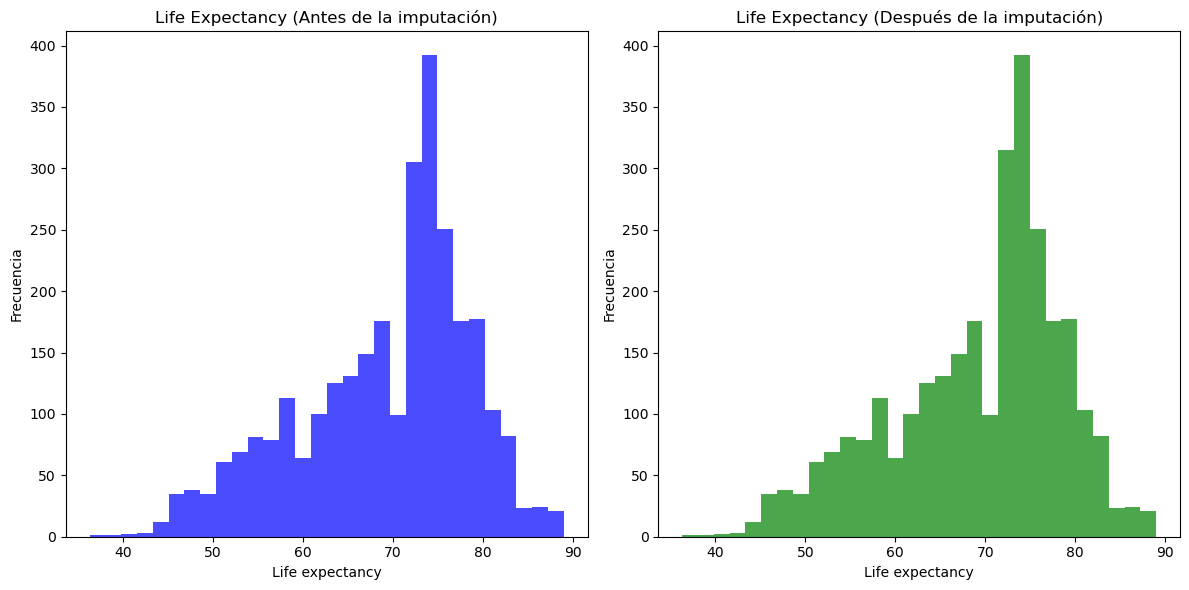

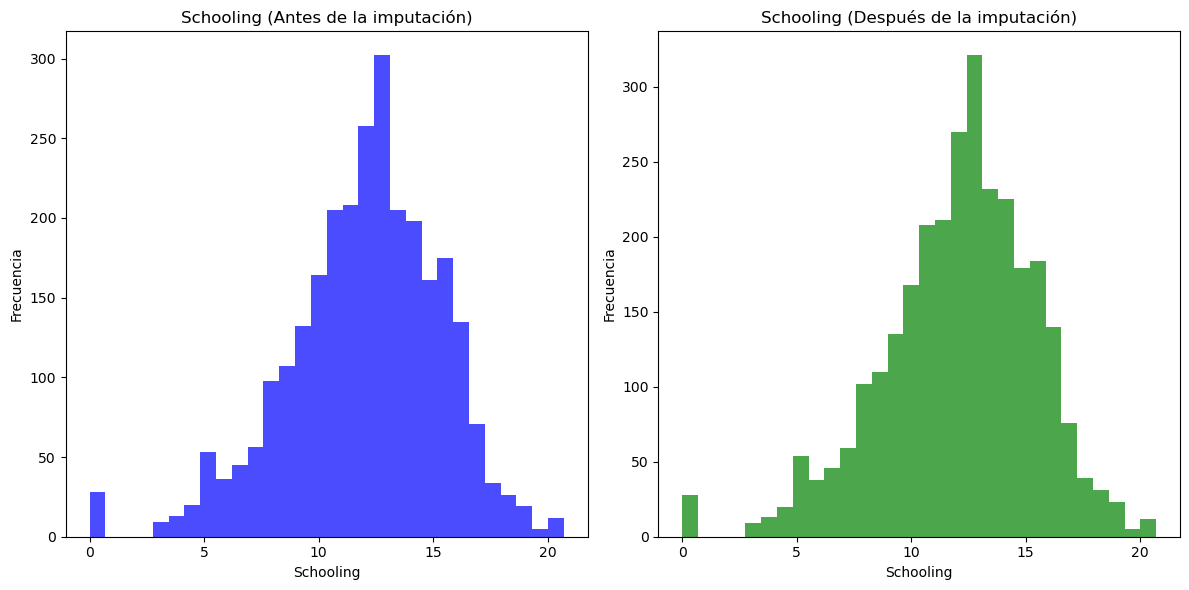

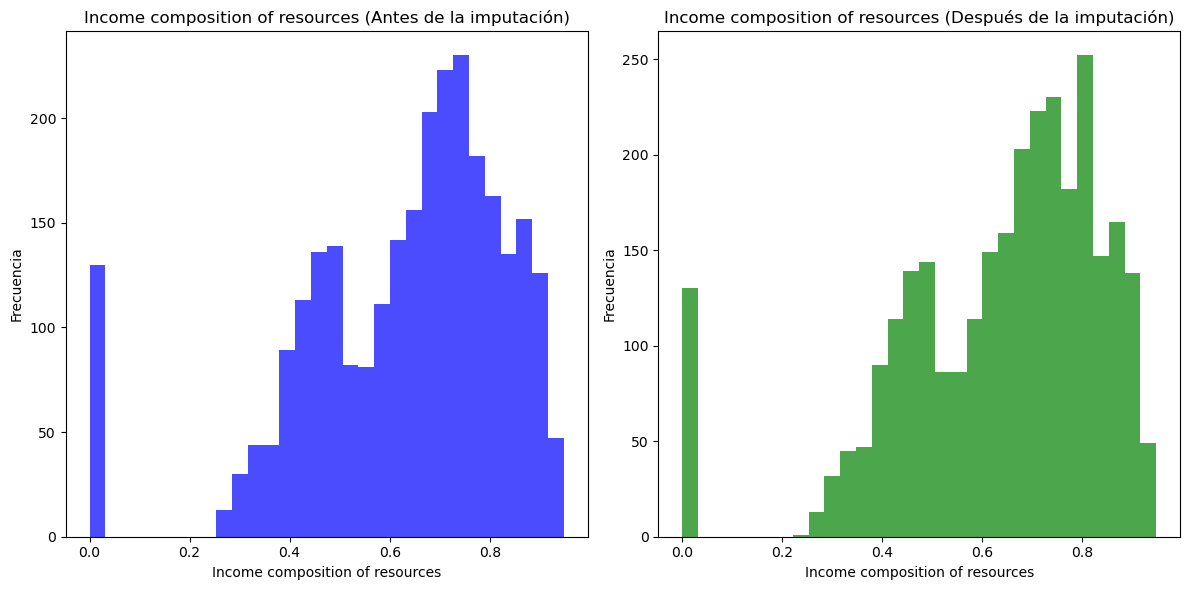

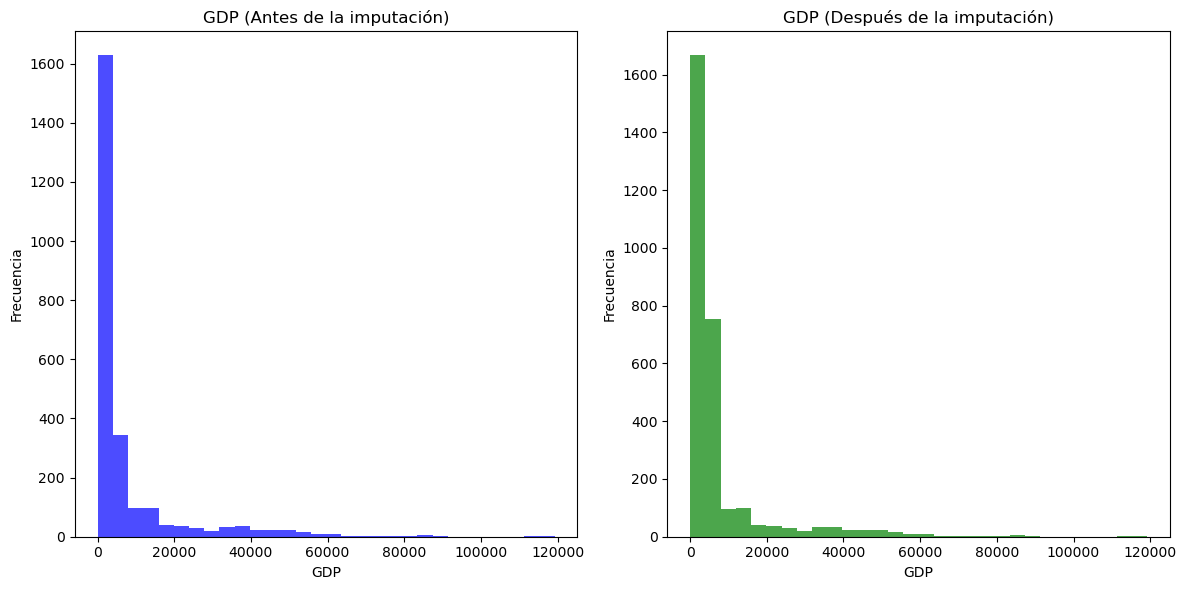

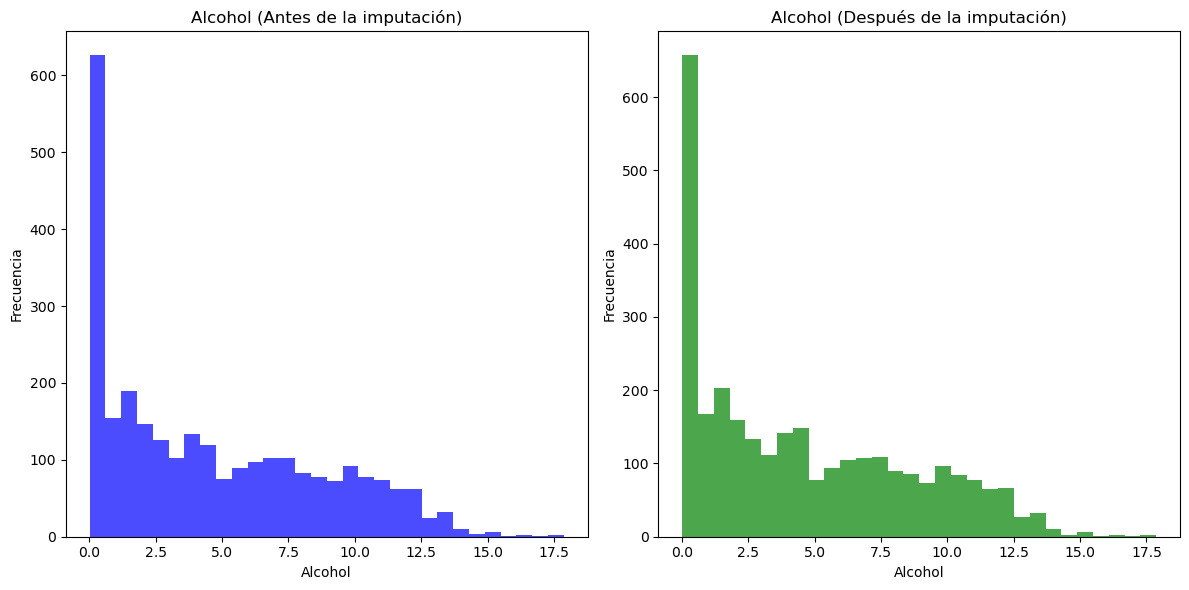

In [42]:
# Función para graficar histogramas de datos antes y después de la imputación
def plot_pre_post_histograms(column, title):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Histograma antes de la imputación
    axes[0].hist(data_before_imputation[column].dropna(), bins=30, alpha=0.7, color='blue')
    axes[0].set_title(f'{title} (Antes de la imputación)')
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Frecuencia')

    # Histograma después de la imputación
    axes[1].hist(data[column], bins=30, alpha=0.7, color='green')
    axes[1].set_title(f'{title} (Después de la imputación)')
    axes[1].set_xlabel(column)
    axes[1].set_ylabel('Frecuencia')

    plt.tight_layout()
    plt.show()

# Graficar los histogramas para las columnas afectadas
plot_pre_post_histograms('Life expectancy', 'Life Expectancy')
plot_pre_post_histograms('Schooling', 'Schooling')
plot_pre_post_histograms('Income composition of resources', 'Income composition of resources')
plot_pre_post_histograms('GDP', 'GDP')
plot_pre_post_histograms('Alcohol', 'Alcohol')

In [43]:
# Seleccionar las columnas predictoras y la variable objetivo

X = data[predictors]
y = data[target]

# Limpieza de columnas
data.columns = data.columns.str.strip()

# Escalado de los predictores
scaler = StandardScaler()
data[predictors] = scaler.fit_transform(data[predictors])

#Revisar datos Nulos
null_values_adjusted = data[predictors + target].isnull().sum()
null_values_adjusted

Schooling                          0
Income composition of resources    0
GDP                                0
Alcohol                            0
Life expectancy                    0
dtype: int64

In [44]:

#Entrenamos el modelo y hacemos validación cruzada para elegir el mejor grado del polinomio para la regresión.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
grados = [1, 2, 3, 4, 5]
mse_valores = []
for grado in grados:
    # Crear características polinómicas del grado actual
    poly = PolynomialFeatures(degree=grado)
    X_train_poly = poly.fit_transform(X_train)
    
    # Crear el modelo de regresión lineal
    model = LinearRegression()
    
    # Realizar validación cruzada
    cv_scores = cross_val_score(model, X_train_poly, y_train, cv=5, scoring='neg_mean_squared_error')
    
    # Guardar el MSE promedio (convertimos el valor negativo que retorna la función a positivo)
    cv_mse = -cv_scores.mean()
    mse_valores.append(cv_mse)
    
    print(f"Grado {grado}: MSE promedio en validación cruzada: {cv_mse}")

#-----------------------------------------------------------------------------------------------------------
param_grid = {'polynomialfeatures__degree': [1, 2, 3, 4, 5]}
pipeline = make_pipeline(PolynomialFeatures(), LinearRegression())

grid_search = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

print(f"Mejor grado de polinomio encontrado: {grid_search.best_params_['polynomialfeatures__degree']}")
#-----------------------------------------------------------------------------------------------------------


Grado 1: MSE promedio en validación cruzada: 42.161827514346655
Grado 2: MSE promedio en validación cruzada: 29.66740554010831
Grado 3: MSE promedio en validación cruzada: 28.289012886833063
Grado 4: MSE promedio en validación cruzada: 324.2308694325302
Grado 5: MSE promedio en validación cruzada: 108.02180773749929
Mejor grado de polinomio encontrado: 3


In [53]:
# Evaluar el modelo: calcular el error cuadrático medio

# Predecir en el conjunto de prueba
y_pred = model.predict(X_test_poly)

mse_test = mean_squared_error(y_test, y_pred)
print(f"Error Cuadrático Medio (MSE) en el conjunto de prueba con polinomio de grado {best_grado}: {mse_test}")

# Evaluar métricas adicionales:
# R^2 - Coeficiente de Determinación
r2 = r2_score(y_test, y_pred)
# MAE - Error absoluto medio
mae = mean_absolute_error(y_test, y_pred)
# RMSE - Raíz del error cuadrático medio
rmse = np.sqrt(mse_test)

# Imprimir los resultados
print(f"Coeficiente R^2: {r2}")
print(f"Error Absoluto Medio (MAE): {mae}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse}")


Error Cuadrático Medio (MSE) en el conjunto de prueba con polinomio de grado 3: 22.033556022225007
Coeficiente R^2: 0.7457687106941208
Error Absoluto Medio (MAE): 3.377634038880669
Raíz del Error Cuadrático Medio (RMSE): 4.693991480842824


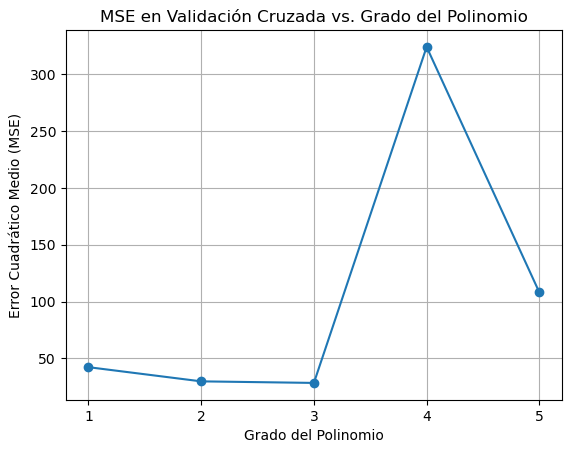

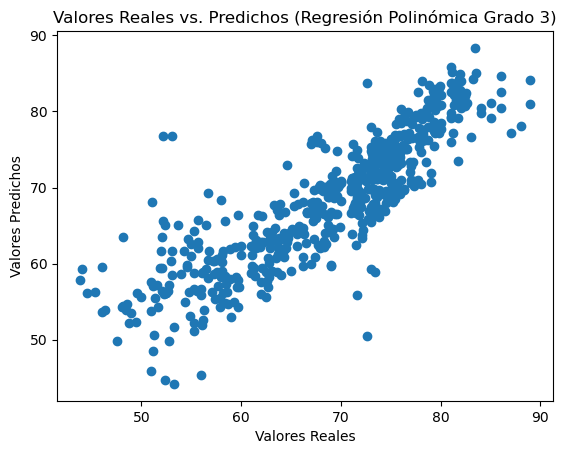

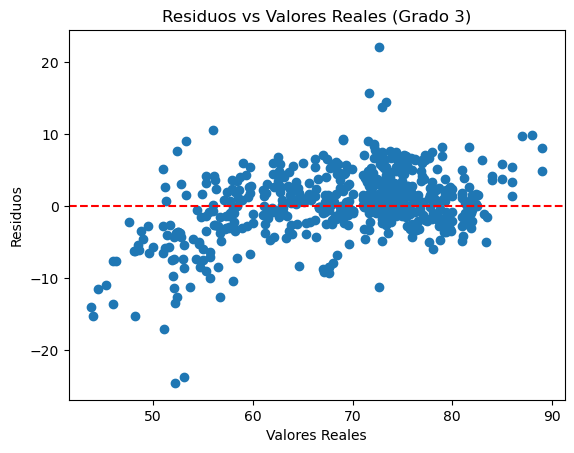

In [54]:
# Graficar los resultados
plt.plot(grados, mse_valores, marker='o')
plt.xlabel("Grado del Polinomio")
plt.ylabel("Error Cuadrático Medio (MSE)")
plt.title("MSE en Validación Cruzada vs. Grado del Polinomio")
plt.xticks(grados)  # Mostrar los grados como valores discretos en el eje x
plt.grid(True)
plt.show()

# Aplicar la transformación polinómica (por ejemplo, grado 2) para el mejor grado encontrado
best_grado = grados[np.argmin(mse_valores)]
poly = PolynomialFeatures(degree=best_grado)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Ajustar el modelo de regresión lineal a los datos polinómicos
model = LinearRegression()
model.fit(X_train_poly, y_train)




# Visualizar la relación entre las predicciones y los valores reales
plt.scatter(y_test, y_pred)
plt.xlabel("Valores Reales")
plt.ylabel("Valores Predichos")
plt.title(f"Valores Reales vs. Predichos (Regresión Polinómica Grado {best_grado})")
plt.show()

#Análisis de resiudos
residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Valores Reales")
plt.ylabel("Residuos")
plt.title(f"Residuos vs Valores Reales (Grado {best_grado})")
plt.show()